## Introduction

In the last lesson, we got to peel back the covers of the `pyplot` interface, just a bit, to see what it was doing behind the scenes. In that lesson, we saw that `pyplot` manages the current `Figure` through a stack of `Figure` objects, where the figure on the top, is the current figure. Doing so makes interacting with matplotlib much easier since we don't have to worry about the creation or destruction of `Figure` objects, or using them to do things like plot some data, save a figure to a file, or even just display a figure. Though this automatic management of the components that make up our plots is liberating, there are problems that can arise when we allow `pyplot` to take care of everything for us without at least some understanding of how it does its work. In this lesson, we'll take a look at one instance where `pyplot`'s insistence on managing the current figure for us can lead to a memory problem if we're not paying close attention.

So, without further ado, let's get our notebook set up.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

## Setup

Just as we did in our last lesson, we want to turn off interactive mode for this lesson, since we want to be in complete control of when figures are displayed and destroyed.

In [2]:
plt.ioff()

The creator's of matplotlib are well aware that having a stateful layer of abstraction can lead to some confusing behavior at times, especially when you don't know how that layer of abstraction is doing its job, and so they've kindly added a few warnings to help out the developer whenever they engage in possibly problematic behavior. These warnings are made using the python standard library's `warnings` module. 

Now, if you're unfamiliar with warnings in python, they work very much like exceptions---in fact, all warnings inherit from the `Exception` class---the main difference is that issuing a warning does not halt your program. Instead, when a warning is issued, depending on the action associated with that warning type, a message is printed to `stderr`, and normal operation is resumed. The default action for all warnings is to be displayed only the first time the warning is issued and never again. The problem with this default behavior for us is that, the very first time we run into a possible problem, we'll see a warning, but every time after the first, it will appear as if nothing is wrong. In other words, we won't be able to tell if we've actually fixed the problem. To be sure that our fix has actually solved the problem, we'll need matplotlib's warnings to show up every time a problem is encountered, and to do that we'll need to change the default behavior for a specific class of warnings. 

In the following bit of code, we import the `warnings` module and change the behavior of the `RuntimeWarning` class to show the warning message every time the problem is encountered and not just the first time.

In [3]:
import warnings
warnings.simplefilter(action="always", category=RuntimeWarning)

## Memory Management

Now that we have our environment properly configured to allow us to explore some bad behavior with the `pyplot` module, we're ready to see what happens when we unknowingly subvert `pyplot`'s automatic handling of the current figure. 

One of the common calls that you'll see in sample matplotlib code, and in an earlier example or two from this course, is a call to the `pyplot.figure` function. Reasons for calling this function vary, but the code below uses it to change the default size of the current figure.

In [4]:
for i in range(21):
    plt.figure(figsize=(5, 5))
    plt.hist(np.random.randn(1000))

/Users/croach/anaconda/envs/mpl/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


So, it looks like our code above got a warning saying that we've created too many figures.

### Why does this happen?

The `pyplot.figure` function, if you'll remember from our last lesson, creates a new instance of the `Figure` class, pushes it onto `pyplot`'s figure stack, and returns the new `Figure` object to the calling function. In short, it will create a new figure, and set it up as the current figure, every time it's called. The reason that this is a problem, is that every time through the loop, we create a new figure and place it on top of the stack, and so our stack just grows and grows, and we can see this by calling the `pyplot.get_fignums` function to show all of the figures in the stack.

In [5]:
plt.get_fignums()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

We can see from the call above, that we currently have 21 active `Figure` objects in the stack---far more than we actually need. 

### How do we solve the problem?

Since the majority of the time that you're interacting with `pyplot`, you're most likely doing some interactive plotting of data, you'll likely never run into this problem as long as you let `pyplot` manage the creation of new `Figure` objects rather than bypassing it by using the `pyplot.figure` function as we just did. The `pyplot` interface normally takes care of everything for you by registering callbacks that destroy the current figure every time it's displayed. This behavior ensures that only one figure exists on the stack at any given time. 

In the case where you're running a script to create and save several figures, instead of interactively plotting your data, you'll again have just one figure on the stack, but if you'll remember from our last lesson, that figure will be reused, so it will be up to you to call the `pyplot.clf` function to clear the current figure every time you want to draw something to it.

So, the only problem here is that our new figures are not being closed. If, however, we were to close the new figure at the end of every loop, that would resolve the problem and make our script act like it normally would had we not bypassed `pyplot`'s management of the current `Figure` object.

In the next cell, we call the `pyplot.close` function and pass in the parameter `"all"` to make sure we close everything in the current stack to reset the `pyplot` stateful interface.

In [6]:
plt.close("all")
# Show the stack just to be sure it's empty
plt.get_fignums()

[]

Then, we perform the exact same task that we did above, however, this time, we'll call the `pyplot.close` function to close the current figure after we've finished with it, i.e., at the end of every loop. Doing so should resolve the issue we saw earlier by making sure that we have, at most, only one figure in our stack at all times.

In [7]:
for i in range(21):
    plt.figure(figsize=(5, 5))
    plt.hist(np.random.randn(1000))
    plt.close()

And, it looks like we're no longer getting a warning because we're now closing each figure manually after we're finished with it. Calling the `pyplot.get_fignums` again should prove it.

In [8]:
plt.get_fignums()

[]

And yes, it does, in fact, look like that's the case, since our figure stack is completely empty.

## Conclusion

So, to recap a bit, the problem we've just seen is that because we may not be aware of how certain parts of the `pyplot` interface work---in this case, the management of `Figure` objects as well as the behavior of the `pyplot.figure` function---we could possibly find ourselves getting into trouble, like running out of memory because of too many figures. We've just seen one solution to this specific problem, which is to simply close each new figure that we create once we're done using it. Another, arguably better, solution would be to get the current figure using the `pyplot.gcf` function, and call the `Figure.set_size_inches` function on it. This solution has the benefit of leaving the creation and destruction of figures still completely with `pyplot`. 

The point here isn't the problem, or the solution for that matter, but the idea that without a decent understanding of how `pyplot` works, you'll find that you continuously run into more problems, and have less success resolving them. On its surface, matplotlib seems very simple, and the `pyplot` interface goes a long way towards making it very user friendly, but once you progress past a simple visualization in an interactive session, you may find that it's much more complex than you had originally anticipated. Luckily, we've worked quite hard over the past two sections to develop a decent understanding of how `pyplot` does its job, so you should be more than prepared to deal with anything it can throw it at you.

Lastly, this lesson concludes the fundamental knowledge that you need to work with matplotlib. In the rest of the lessons in this course, we'll switch gears a bit from understanding how matplotlib works, to seeing what's possible with the library now that you have a basic understanding of how to use it. Over the next several lessons, you'll learn how to do things like animate your data, display data in maps, work interactively with your visualizations using UI components, to name just a few of the topics that we'll be covering.

## BONUS: Digging Deeper

For those of you that want to actually see the default behavior in action, the next cell will use the `Logger` and `PrintLnFunc` callable classes from our last lesson to decorate the `pyplot.figure` and `pyplot.close` functions.

As I've mentioned before, for the interactive backends, a callback function is used to close each figure once it's been displayed. Incidentally, that callback function is the `_pylab_helpers.destroy` function, if you want to do a little further investigation on your own. However, when using matplotlib with the inline backend for a Jupyter notebook, as we are here, the IPython kernel simply calls the `pyplot.close("all")` function at the end of each call to the `ipykernel.pylab.backend_inline.show` function. The end result, in either case, is that `pyplot.close` function eventually gets called every time a figure is shown making sure that only one figure exists in the stack at any time.

So, let's go ahead and set up our environment to print out the calls to the `pylot.figure` and `pyplot.close` functions.

In [9]:
class PrintlnFunc(object):
    def __init__(self):
        self.line = 1
    def __call__(self, msg):
        print "%2d. %s" % (self.line, msg)
        self.line += 1
    def reset(self):
        self.line = 1
println = PrintlnFunc()

class Logger(object):
    """Wraps a function in a callable that prints call information
    """
    level = 0

    def __init__(self, fn):
        self.fn = fn

    def __call__(self, *args, **kwargs):
        # Create the padding string according to the current level in the call
        # stack, and increase the level since we're about to pop another 
        # function onto the stack.
        padding = "|" + "-" * (Logger.level * 4 - 1) if Logger.level > 0 else ""
        Logger.level += 1

        # Print calling information, call the function, and print returning info
        println("%sCalling %s.%s" % (padding, self.fn.__module__, self.fn.__name__))
        result = self.fn(*args, **kwargs)
        println("%sReturning <%s:%s> from %s.%s" % \
            (padding, result.__class__.__name__, id(result), self.fn.__module__, self.fn.__name__))

        # Decrease the call stack level, since we are returning.
        Logger.level -= 1
        return result
    
# Decorate a couple of pyplot functions with Logger
plt.figure = Logger(plt.figure)
plt.close = Logger(plt.close)

And then, we'll call the `pyplot.close` function with the `"all"` parameter to make sure our stack is empty before we start.

In [10]:
plt.close("all")
println.reset()

 1. Calling matplotlib.pyplot.close
 2. Returning <NoneType:4296543296> from matplotlib.pyplot.close


Finally, we'll do the same loop as we did above, but this time we'll actually display the result of the call to the `pyplot.hist` function.

 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4515923728> from matplotlib.pyplot.figure


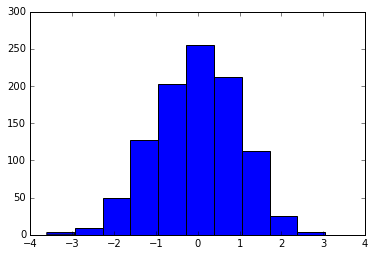

 3. Calling matplotlib.pyplot.close
 4. Returning <NoneType:4296543296> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4539312592> from matplotlib.pyplot.figure


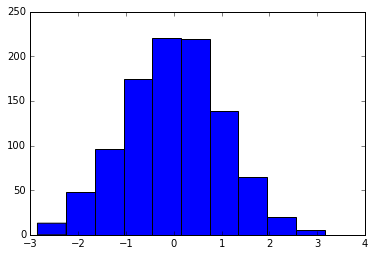

 3. Calling matplotlib.pyplot.close
 4. Returning <NoneType:4296543296> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4515835856> from matplotlib.pyplot.figure


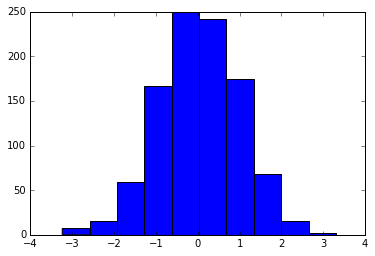

 3. Calling matplotlib.pyplot.close
 4. Returning <NoneType:4296543296> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4524507728> from matplotlib.pyplot.figure


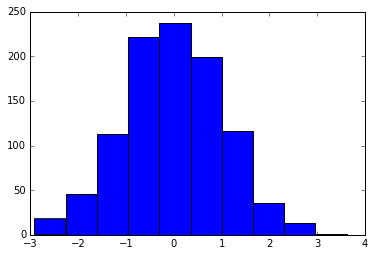

 3. Calling matplotlib.pyplot.close
 4. Returning <NoneType:4296543296> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4521381968> from matplotlib.pyplot.figure


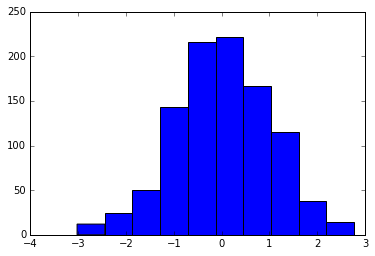

 3. Calling matplotlib.pyplot.close
 4. Returning <NoneType:4296543296> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4519316624> from matplotlib.pyplot.figure


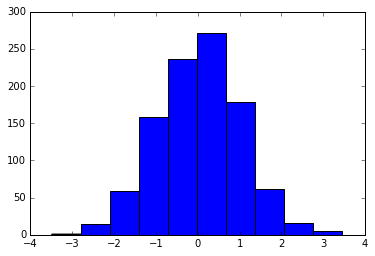

 3. Calling matplotlib.pyplot.close
 4. Returning <NoneType:4296543296> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4523982736> from matplotlib.pyplot.figure


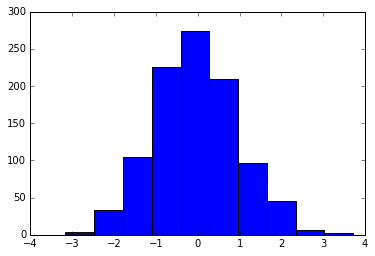

 3. Calling matplotlib.pyplot.close
 4. Returning <NoneType:4296543296> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4519317136> from matplotlib.pyplot.figure


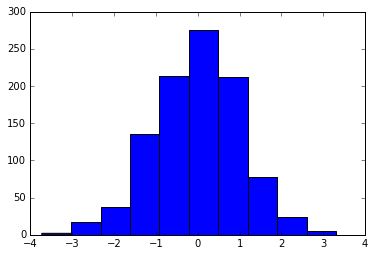

 3. Calling matplotlib.pyplot.close
 4. Returning <NoneType:4296543296> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4512454544> from matplotlib.pyplot.figure


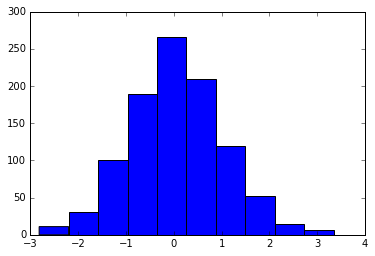

 3. Calling matplotlib.pyplot.close
 4. Returning <NoneType:4296543296> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4527907472> from matplotlib.pyplot.figure


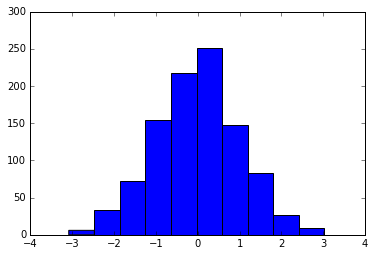

 3. Calling matplotlib.pyplot.close
 4. Returning <NoneType:4296543296> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4509858704> from matplotlib.pyplot.figure


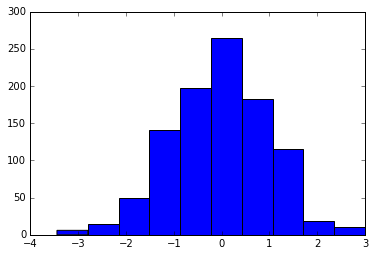

 3. Calling matplotlib.pyplot.close
 4. Returning <NoneType:4296543296> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4520881360> from matplotlib.pyplot.figure


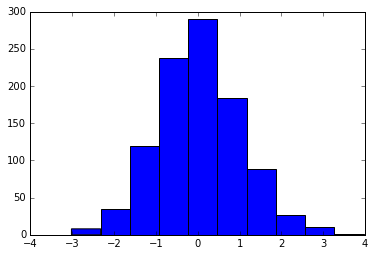

 3. Calling matplotlib.pyplot.close
 4. Returning <NoneType:4296543296> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4545670544> from matplotlib.pyplot.figure


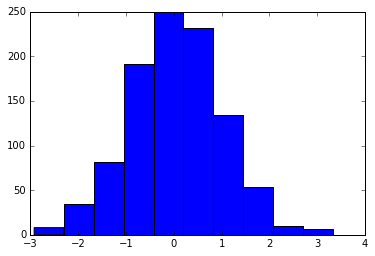

 3. Calling matplotlib.pyplot.close
 4. Returning <NoneType:4296543296> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4527255248> from matplotlib.pyplot.figure


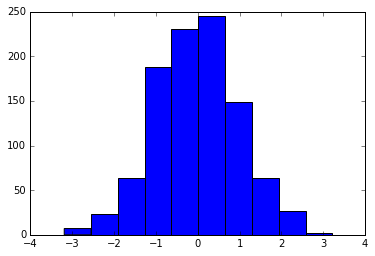

 3. Calling matplotlib.pyplot.close
 4. Returning <NoneType:4296543296> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4546315280> from matplotlib.pyplot.figure


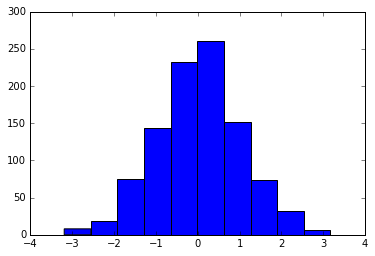

 3. Calling matplotlib.pyplot.close
 4. Returning <NoneType:4296543296> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4546012944> from matplotlib.pyplot.figure


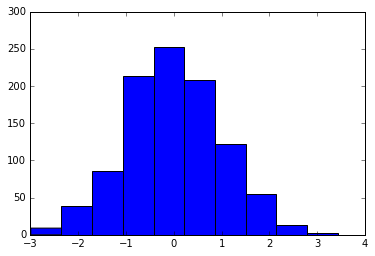

 3. Calling matplotlib.pyplot.close
 4. Returning <NoneType:4296543296> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4526611984> from matplotlib.pyplot.figure


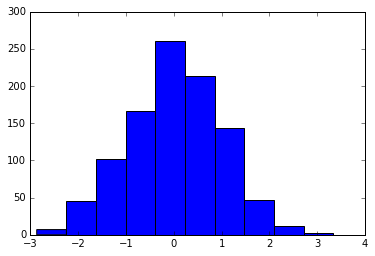

 3. Calling matplotlib.pyplot.close
 4. Returning <NoneType:4296543296> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4513717200> from matplotlib.pyplot.figure


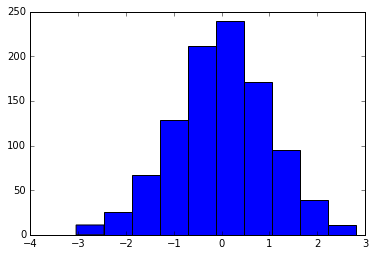

 3. Calling matplotlib.pyplot.close
 4. Returning <NoneType:4296543296> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4527161168> from matplotlib.pyplot.figure


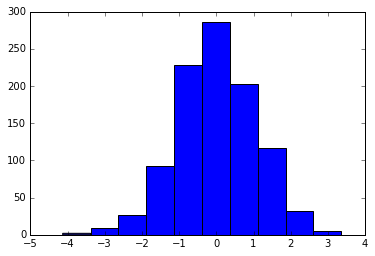

 3. Calling matplotlib.pyplot.close
 4. Returning <NoneType:4296543296> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4546081296> from matplotlib.pyplot.figure


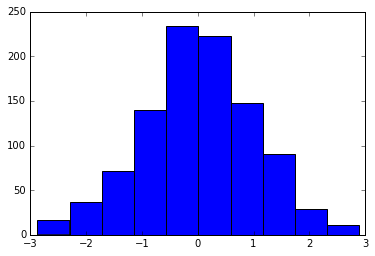

 3. Calling matplotlib.pyplot.close
 4. Returning <NoneType:4296543296> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4471383248> from matplotlib.pyplot.figure


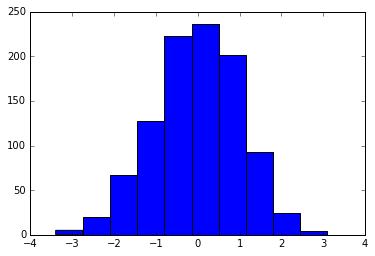

 3. Calling matplotlib.pyplot.close
 4. Returning <NoneType:4296543296> from matplotlib.pyplot.close
-------------------------------------------------------------------------------


In [11]:
for i in range(21):
    plt.figure()
    plt.hist(np.random.randn(1000))
    plt.show()
    print '-'*79
    println.reset()

And, as you can see, we're no longer getting the warning message that we saw earlier even though we're still calling the `pyplot.figure` function, and we're not actively closing each new figure. The reason, as we can also see in the print information above, is that the `pyplot.close` function is being called for us after the `pyplot.show` function is finished executing.

And, once again, we can display the current stack by calling the `pyplot.get_fignums` function to verify that all figures have been properly closed.

In [12]:
plt.get_fignums()

[]